In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller 
from sklearn.metrics import mean_squared_error, mean_absolute_error 



# Abrir e processar o CSV com os dados

In [3]:
df = pd.read_csv('./data/candy_production.csv')
df = df.rename(columns={'observation_date': 'date', 'IPG3113N':'production'})
df.index = pd.DatetimeIndex(data= df.date)
df = df.drop(columns=['date'])
df.head()


,production
date,
1972-01-01,85.6945
1972-02-01,71.8200
1972-03-01,66.0229
1972-04-01,64.5645
1972-05-01,65.0100


# VIZUALIZAÇÃO

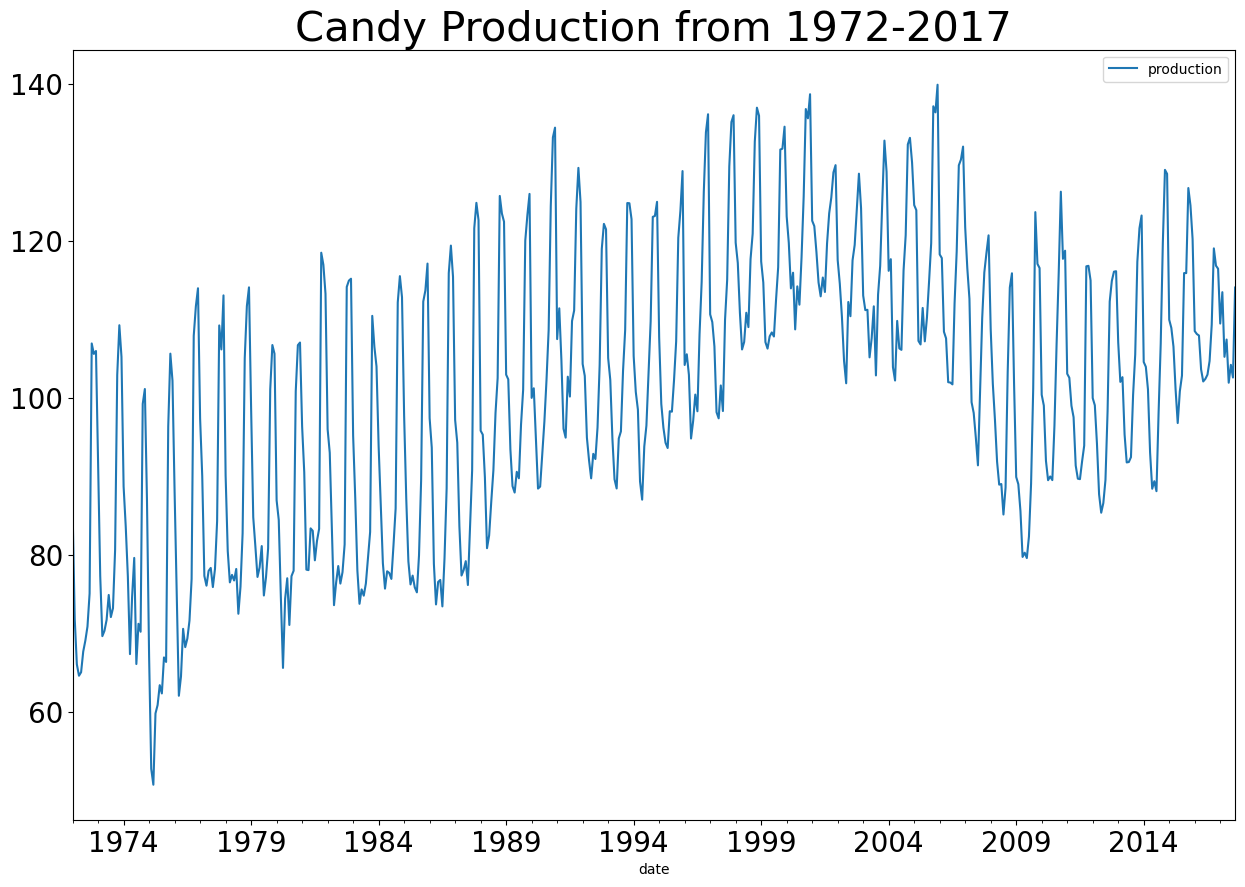

In [4]:
df.plot(figsize=(15, 10), fontsize=20)
plt.title('Candy Production from 1972-2017', fontsize=30)
plt.show()

In [37]:
## Observando a estacionaridade dos dados
result = adfuller(df["production"]) 
p_value = result[1] 
print(f'ADF Statistic: {result[0]}') 
print(f'p-value: {p_value}') 
print('Stationary' if p_value < 0.05 else 'Non-Stationary') 

ADF Statistic: -1.8870498112252831
p-value: 0.33817759730042785
Non-Stationary


<Figure size 640x480 with 0 Axes>

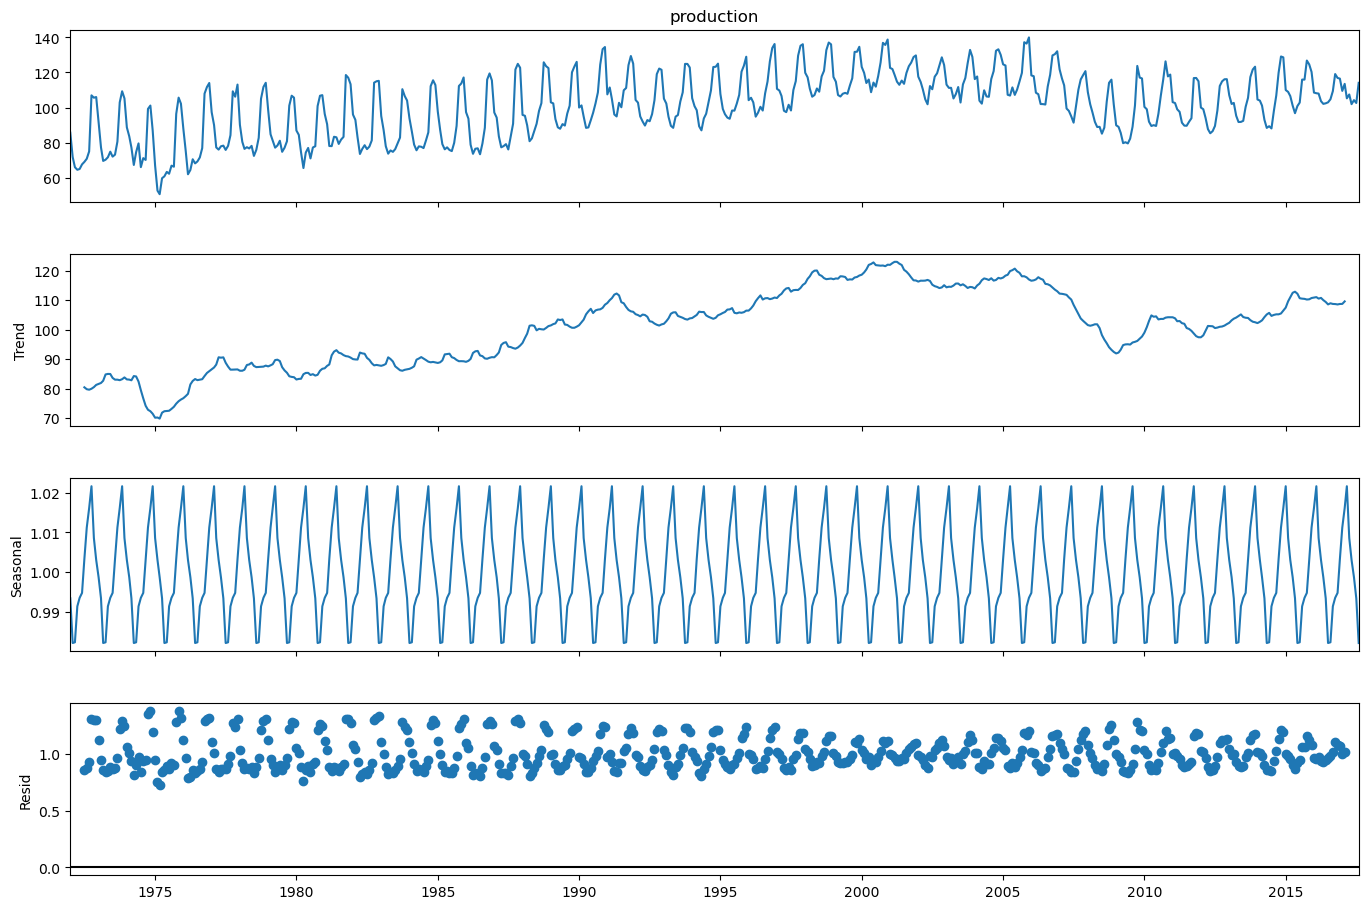

In [38]:
result = seasonal_decompose(df["production"], model='multiplicative', period=13)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 10)

## Parametros ARIMA (p, d, q)

p -> Autocorrelação Proporcional (AR) - O quanto os dados passados afetam o presente

d -> 0 ou 1 Para parte diferencial (I) - Diferenciações para que os dados sejam estacionario

q -> Autocorrelação Parcial (MA) - O erro histórico que afeta o valor atual

## Parametros SARIMA (p, d, q)(P,D,Q, s)

P -> Ordem da sazonalidade AR

D -> Integração da sazonalidade

Q -> Ordem da sazonalidade MA

s -> frequencia

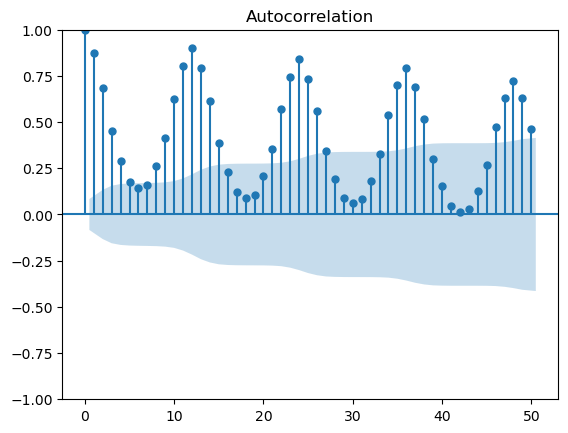

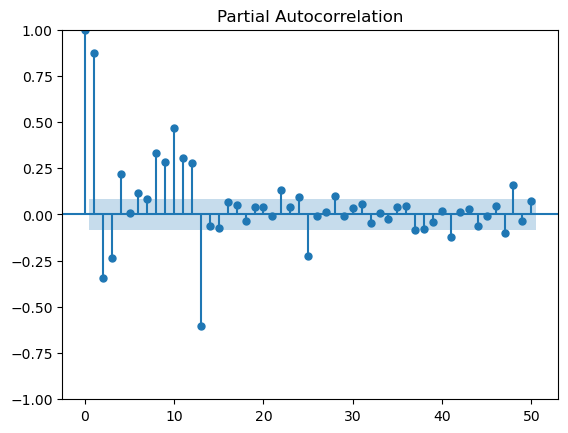

In [7]:
acf = plot_acf(df["production"], lags = 50)
pacf = plot_pacf(df["production"], lags = 50)
plt.show()

Retiramos que s=13 pois é a frequencia observada no ACF. Além disso, vemos um p=5 no ACF e um q=2 no PACF. Como os dados não são estacionarios d=1.

<Axes: xlabel='date'>

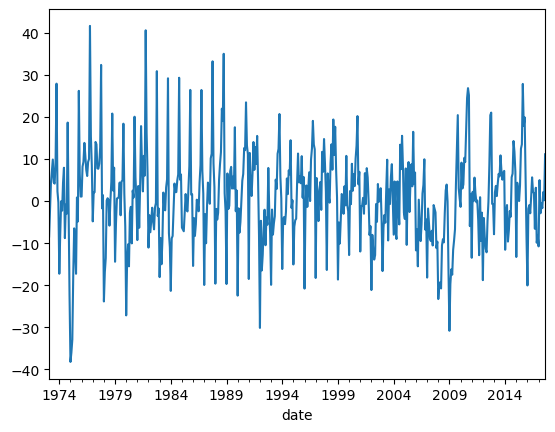

In [13]:
dff = df["production"].diff(13).dropna()
dff.plot()

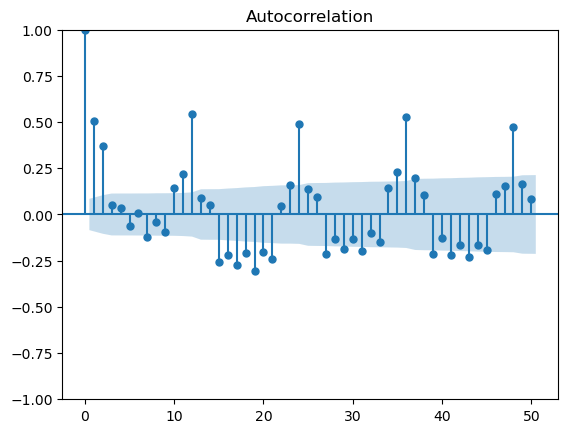

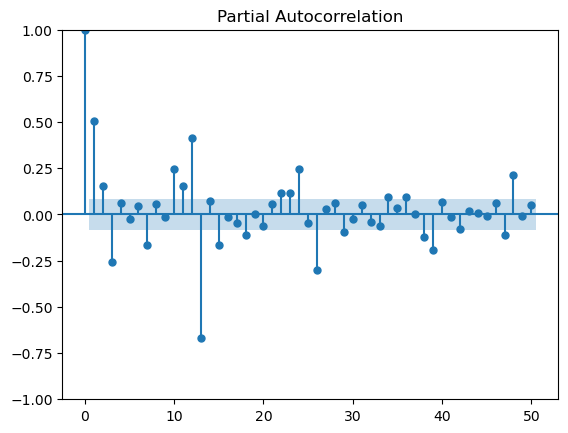

In [14]:
dff = df["production"].diff(13).dropna()

acf = plot_acf(dff, lags = 50)
pacf = plot_pacf(dff, lags = 50)
plt.show()

Retiramos então que P=3 e Q=3.

# Construção do modelo

## Dividindo os dados em treino e teste

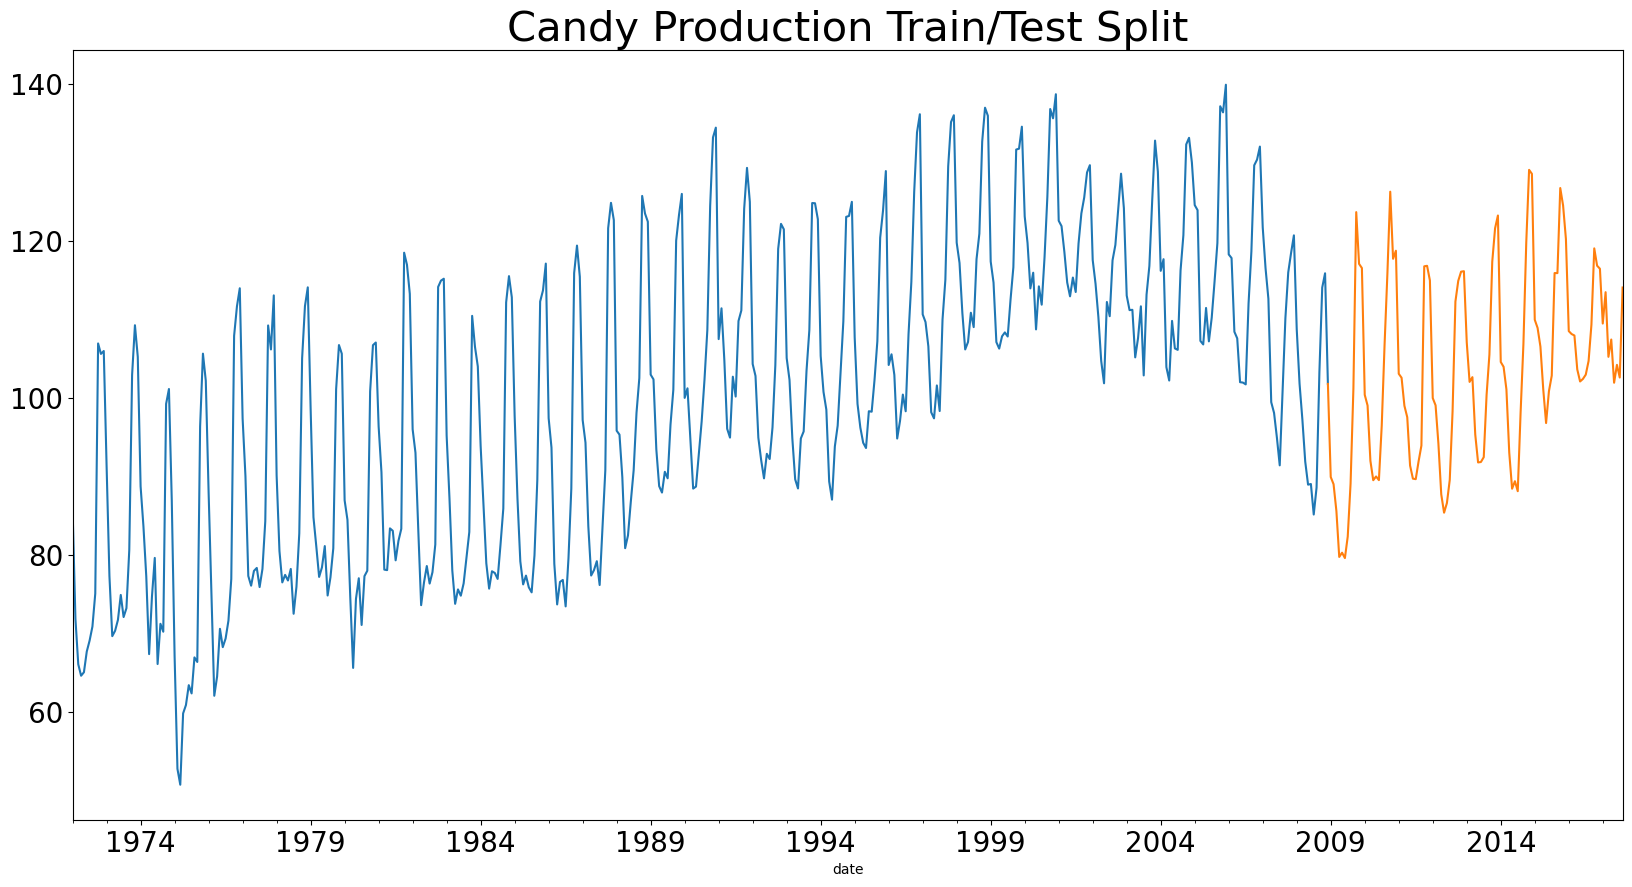

In [16]:
split_date = '2008-12-01'
train = df['production'].loc[:split_date]
test = df['production'].loc[split_date:]
train.plot(figsize=(20, 10), fontsize=20)
plt.title('Candy Production Train/Test Split', fontsize=30)
test.plot()
plt.show()

## Construindo o modelo

In [52]:
p, d, q = 5, 1, 2
P, D, Q, s = 3, 0, 3, 13
model = SARIMAX(train, order=(p,d,q), seasonal_order=(P,D,Q, s))  
model = model.fit(disp=-1)  
print(model.summary())

c:\Users\Capati\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Capati\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Capati\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Capati\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Capati\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maxi

                                         SARIMAX Results                                          
Dep. Variable:                                 production   No. Observations:                  444
Model:             SARIMAX(5, 1, 2)x(3, 0, [1, 2, 3], 13)   Log Likelihood               -1432.857
Date:                                    Mon, 08 Jul 2024   AIC                           2893.715
Time:                                            16:50:24   BIC                           2951.025
Sample:                                        01-01-1972   HQIC                          2916.317
                                             - 12-01-2008                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1450      0.117     -9.783      0

## Fazendo as previsões e avaliando a performance

In [55]:
fcast_len = len(test)
forecast = model.forecast(fcast_len)

mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test, forecast)
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 76.61345316677081
Root Mean Squared Error: 8.75291112526403
Mean Absolute Error: 7.209861804415925


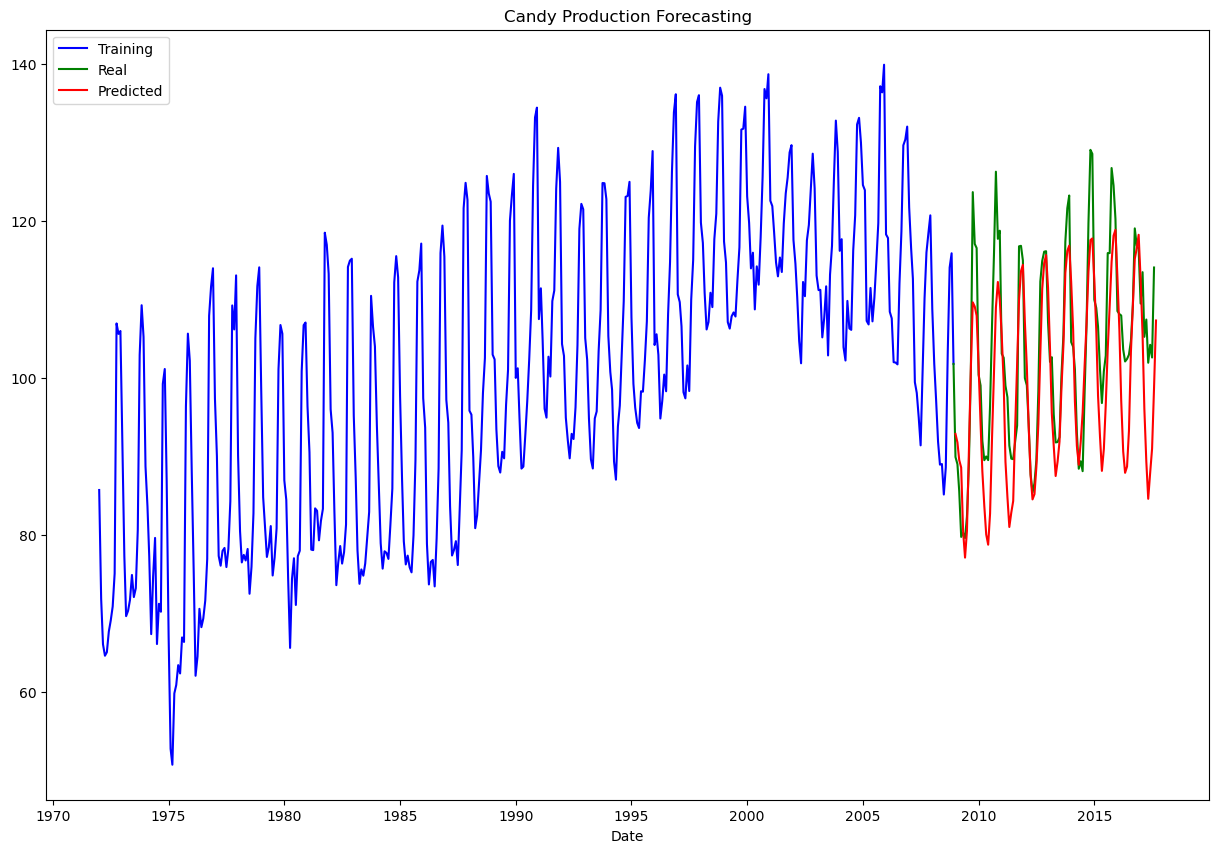

In [56]:
fig, ax = plt.subplots(figsize=(15,10))

ax.set(title='Candy Production Forecasting', xlabel='Date')

ax.plot(train.index, train, label='Training', color='blue')
ax.plot(test.index, test, label='Real', color='green')
ax.plot(forecast.index, forecast, label='Predicted', color='red'
)
ax.legend(loc='upper left')